Validation notebook to confirm that we can recover SRD fisher with applying SRD prior and linear PS predictions. Linear non-linear IA + baryons + MG params + scale dependent MG. Here instead of Omega_c, use OmegaM

Ωm (0.3156; 0.2); σ8 (0.831; 0.14); ns (0.9645; 0.08); w0 (-1.0; 0.8); wa (0.0; 2.0); Ωb (0.0492; 0.006); h (0.6727; 0.063). Note that we are fixing the neutrino mass mν = 0 for the forecasts in the baseline analysis even though neutrinos have mass.


the params_fiducial values used here are not the same as in other validfation notebooks - different values or omega_b and w, more signicant digits for h0 and ns 

In [2]:
import numpy as np
import pyccl as ccl
import pylab as plt
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
import matplotlib.pyplot as pl
#import fisher_module as fisher

In [3]:
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 18.0
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True

In [4]:
#Set up a dictionary of test parameters (this is used to check that the data vector is looking correct) #A_IA=1.6 would be kids-like
params_fiducial_test = {'Omega_m': 0.3156,\
                           'Omega_b': 0.0492,\
                           'h': 0.6727,\
                           'A_s_norm': 2.1,\
                           'sigma_8':0.831,\
                           'n_s': 0.9645,\
                           'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
                           'w0': -0.9,\
                           'wa': 0,\
                           'mu_0': 0,\
                           'sigma_0': 0,\
                           'bcm_log10': 14.07918,\
                           'bcm_etab': 0.5,\
                           'bcm_ks': 55.0,\
                           'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],
                           'A_IA':5,\
                           'eta_IA':0,\
                           'c1_mg':1.0,\
                           'c2_mg':1.0,\
                           'lambda_mg':0.0}

In [5]:
class fisherob:
    
    #initialise fisher, takes in an array of parameter names and an array of derivatives in shape[vector length, # of parameters]
    #the param_names must go in the same order as corresponding derivatives in param_derivatives
    #can also just give finished matrix and param names
    def __init__(self, param_names, param_derivatives=None, inverse_cov=None, fisher_array=None, mean_vals=None):
        self.fisher = fisher_array
        self.names = np.array(param_names)
        self.derivatives = param_derivatives
        self.inv_cov = inverse_cov
        self.param_cov = None
        self.means = mean_vals
        
    #function to create fisher     
    def makefisher(self):
        
        if self.fisher is None:
            self.fisher = np.zeros([len(self.names), len(self.names)]) #create empty array of shape that matches #of params
            for ii in range(len(self.names)):
                for jj in range(len(self.names)):
                    self.fisher[ii][jj] = np.matmul(self.derivatives[:,ii], (np.matmul(self.inv_cov, self.derivatives[:,jj])))
        else: print("Please set your current array to None before proceeding")   
                    
    #removes columns and rows that correspond to named params from fisher matrix (also removes associated names and derivatives)
    #removing parameters means we assume constant values
    def remove_elements(self, names_remove):
        names_remove=np.array(names_remove)
        ids_remove = []
        for name in names_remove:
            ids_remove.append(np.where(self.names==name)[0][0])
        print (ids_remove)
        
        fisher_removed = np.delete(self.fisher, ids_remove, 0)
        fisher_removed = np.delete(fisher_removed, ids_remove, 1)
        
        self.names = np.delete(self.names, ids_remove)
        self.derivatives = np.delete(self.derivatives, ids_remove, 1)
        
        self.fisher = fisher_removed
        print("Removed "+str(names_remove)+". Fisher shape: "+str(self.fisher.shape))
        print("Derivatives shape: "+str(self.derivatives.shape))
    
    #to check one sigma errors
    def get_sigmas(self):
        print (np.sqrt(np.diag(self.fisher))**(-1))
        
    #parameter covariance matrix is inverse of the fisher matrix so calculate parameter covariances for each fisher  
    #also checks that stds and eigenvalues are positive!
    def get_cov(self):
        self.param_cov = np.linalg.inv(self.fisher)
        if np.where(np.diag(self.param_cov)<0)[0].size==0: print("The stds are positive - you're good to go!")
        else: 
            print("WARNING: Some stds may be negative, please check!")
            print ("These are the stds: "+str(np.diag(self.param_cov)))
        
        if np.where(np.linalg.eig(self.param_cov)[0]<0)[0].size==0: print("The eigenvalues are positive - you're good to go!")
        else: 
            print("WARNING: Some eigenvalues may be negative, please check!")
            print ("These are the eigenvalues: "+str(np.linalg.eig(self.param_cov)[0]))
            if np.where(np.linalg.eig(self.fisher)[0]<0)[0].size==0: print("fisher eigenvalues are positive!")
            else: print("some of the fisher eigenvalues are negative too - check construction!")
            
    #in addition to self.param_cov, this allows to create and store a smaller version of original covariance matrix with some of the parameters removed - useful for plotting       
    def get_cov_cosmo(self, names_keep):
        
        #names_keep = ['n_s', 'w0', 'wa', 'omega_b', 'h0']
        #find names of al the elements that are not in names_keep
        names_remove = list(set(self.names.tolist()).difference(names_keep))
        ids_remove = []
        for name in names_remove:
            ids_remove.append(np.where(self.names==name)[0][0])

        
        cov_cosmo = np.delete(self.param_cov, ids_remove, 0)
        cov_cosmo = np.delete(cov_cosmo, ids_remove, 1)
        
        names_cosmo = np.delete(self.names, ids_remove)
        
        self.cov_cosmo = cov_cosmo
        self.names_cosmo = names_cosmo
        print ("added cosmo covariance with shape "+str(self.cov_cosmo.shape))
    
    # reshuffles the smaller self.cov_cosmo covariance so that the order of parameters matches the order in new_names
    def reshuffle_cosmo(self, new_names):
        if self.cov_cosmo is None: print("Please create the cosmo covariance first")
        print ("This will update the self.cov_cosmo and self.names_cosmo ") 
        upd_cov = np.zeros(self.cov_cosmo.shape)
        old_id = [] #old ids will be appended in the order that we want them in final matrix
        for ii in range(len(new_names)):
            new_id = int(ii)
            old_id.append(np.where(self.names_cosmo==new_names[ii])[0][0])
        
        for xx in range(len(upd_cov)):
            for yy in range(len(upd_cov)):
                #print (xx)
               # print (yy)
                #print (old_id[yy])
                #print ()
                upd_cov[yy][xx] = self.cov_cosmo[old_id[yy]][old_id[xx]]
                
        self.cov_cosmo = upd_cov
        self.names_cosmo = new_names
    
    # functionality to add priors to fisher_matrix: prior_fisher does not have to match the current matrix, prior_params must describe prior_fisher in correct order
    def add_prior(self, prior_fisher, prior_params):
        
        if self.param_cov is None: 
            prior_params = np.array(prior_params)
            
            if np.array_equal(prior_params, self.names) == True:
            #if prior_params.all() == self.names.all(): 
                print ("The current fisher is in the same order as your prior - it wil be added")
                self.fisher = self.fisher + prior_fisher
            
            
            else: 
                print ("The parameters in current fisher do not match your prior - let me deal with this!")
                prior_fisher_empty = np.zeros([len(self.names), len(self.names)])
                fisher_id =[] #this will contain the indices that each of prior_params are at in self.names
                for ii in range(len(prior_params)):
                    if prior_params[ii] in self.names: fisher_id.append(np.where(prior_params[ii]==self.names)[0][0]) #find where the prior parameter is in original matrix
                    else: fisher_id.append(np.nan) #if prior_param does not exist in this fisher, id will be a nan instead
                
                for xx in range(len(prior_params)):
                    for yy in range(len(prior_params)):
                        newx = fisher_id[xx]
                        newy = fisher_id[yy]
                        if np.isnan(newx)==False and np.isnan(newy)==False: prior_fisher_empty[newy][newx] = prior_fisher[yy][xx]
            
                self.fisher = self.fisher + prior_fisher_empty
        else: print ("Yor covariance was already created - if you want priors on that, please impose before inversion.")
        

In [13]:
def data_vector(params, power_set):
    '''This function takes a parameter argument which is a list of dictionaries used to vary one specific parameter,
    it then calculates the data vectors for each dict, allowing for the effects of varying each cosmological parameter
    on the data vectors form to be analysed'''
    
    params['Omega_c'] = params['Omega_m'] - params['Omega_b'] # for masselss neutrinos
    
    #Set up the cosmology object with all parameters being used
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          A_s = params['A_s_norm']*10**(-9),\
                          n_s = params['n_s'],\
                          w0 = params['w0'],\
                          wa = params['wa'],\
                          mu_0 = params['mu_0'],\
                          sigma_0 = params['sigma_0'],\
                          bcm_log10Mc = params['bcm_log10'],\
                          bcm_etab = params['bcm_etab'],\
                          bcm_ks = params['bcm_ks'],\
                          matter_power_spectrum = power_set,\
                          transfer_function = 'boltzmann_camb' ,\
                          baryons_power_spectrum = "bcm",\
                          c1_mg = params['c1_mg'],\
                          c2_mg = params['c2_mg'],\
                          lambda_mg = params['lambda_mg'])
    
    #Load in lensing and clustering distributions and ell data
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects for clustering lensing and gg-lensing
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        
        ia_const = 5e-14 / params['h']**2 #Mpc^3 /M_sol
        z0 = 0.3 #kids-like also in Kreuse 2016
        aa_lens = 1./(1.+dNdz_lens[:,0])
        #factor = -1*params['A_IA'] * ia_const * get_critical_density(params['h']) * ccl.background.omega_x(cosmo, 1., 'matter') / ccl.background.growth_rate(cosmo, aa_lens) * ((1. + dNdz_lens[:,0]) / (1. + z0))**params["eta_IA"]
        
        #Kreuse 2016
        C1ro_c = 0.0134
        factor = params['A_IA']*(C1ro_c/ccl.background.growth_rate(cosmo, aa_lens))*((1+dNdz_lens[:,0])/(1+z0))**params["eta_IA"]
        
        #factor = params['ia_bias'][i] #original set up
        
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'][i]*np.ones(2000))))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo,\
                                                  dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1]),\
                                                  ia_bias=(dNdz_lens[:,0], factor*np.ones(2000))))
    
    #Now that the tracers are constructed, calculate C_l's for clustering, gg-lensing and shear
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    #this concerns the specific redshift bins that are to be eliminated from the gg-lensing cl data
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    
    #append calculated cl values to the cl lists for each respective effect 
    for i in range(len(tracers_clust)):
        
        cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
        
        for j in range(len(tracers_clust)):
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    for n in range(len(gglensing)):
        if gglensing[n] == 1:
            cls_gg_clean.append(cls_gg[n])

    #Clean up the data vectors shapes and combine them all
    cls_lens = np.append(cls_lens, cls_gg_clean)
    cls_combined = np.append(cls_lens, cls_clus)
    
    return cls_combined

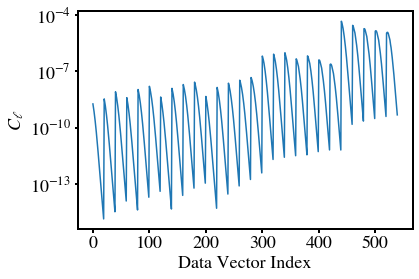

In [7]:
#Check that the data vector is looking as it should be (in comparison to the LSST one) - the order that must be used for
#this analysis is shear-gglensing-clustering as this matches the order for the covariance matrix used in the later fisher calculation

data_vector_fiducial = data_vector(params_fiducial_test, 'linear')

plt.plot(data_vector_fiducial)
plt.yscale('log')
plt.ylabel('$C_\ell$')
plt.xlabel('Data Vector Index')
plt.show()

In [14]:
def numerical_deriv(param,h, power_set):
    '''This function takes a parameter "param" and a value for h to calculate the numerical derivative with respect to param of
    each index of the c_ell value data vector. Note - h is as a percentage of the fiducial value of the parameter "param".
    This is done through the use of the 5 point finite difference method. This function only takes inputs of a string for 
    "param" and a positive value of h.'''
    if type(param) != str:
        print('Please input a parameter name as a string')

    if h <= 0:
        print('Please input a positive, non-zero value for h')
        
        
        
    #Define the fiducial parameters for the model that will be varied by h%
    #Since the values for mu0 sig0 and wa are 0 initially, set these to some small values to allow for the
    #derivative function to work properly 
    if param == 'mu_0' or param == 'sigma_0' or param == 'wa':
        params_fiducial = { 'Omega_b': 0.0492,\
                            'Omega_m': 0.3156,\
                            'h': 0.6727,\
                            'A_s_norm': 2.1,\
                            'sigma_8': 0.831,\
                            'n_s': 0.9645,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.1,\
                            'mu_0': 0.1,\
                            'sigma_0': 0.1,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                            'A_IA':5,\
                            'eta_IA':0,\
                            'c1_mg':1.0,\
                            'c2_mg':1.0,\
                            'lambda_mg':0.1}
    elif param == 'eta_IA':
        params_fiducial = { 'Omega_b': 0.0492,\
                            'Omega_m': 0.3156,\
                            'h': 0.6727,\
                            'A_s_norm': 2.1,\
                            'sigma_8': 0.831,\
                            'n_s': 0.9645,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': 0.0,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                            'A_IA':5,\
                            'eta_IA':0.1,\
                            'c1_mg':1.0,\
                            'c2_mg':1.0,\
                            'lambda_mg':0.1}
        
    elif param == 'lambda_mg' or param =='c1_mg' or param =='c2_mg':
        params_fiducial = { 'Omega_b': 0.0492,\
                            'Omega_m': 0.3156,\
                            'h': 0.6727,\
                            'A_s_norm': 2.1,\
                            'sigma_8': 0.831,\
                            'n_s': 0.9645,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': 0.0,\
                            'wa': 0.0,\
                            'mu_0': 1.0,\
                            'sigma_0': 1.0,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                            'A_IA':5,\
                            'eta_IA':0,\
                            'c1_mg':1.0,\
                            'c2_mg':1.0,\
                            'lambda_mg':0.1}
        
    else:
        params_fiducial = {'Omega_m': 0.3156 ,\
                            'Omega_b': 0.0492,\
                            'h': 0.6727,\
                            'A_s_norm': 2.1,\
                            'sigma_8': 0.831,\
                            'n_s': 0.9645,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0':  -0.9,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                            'A_IA':5,\
                            'eta_IA':0,\
                            'c1_mg':1.0,\
                            'c2_mg':1.0,\
                            'lambda_mg':0.1}

    #Create a dictionary list that varies the specified parameter by -2h,-h,h,2h
    
    params_pos2h  = {'Omega_m': 0.3156,\
                        'Omega_b': 0.0492,\
                        'h': 0.6727,\
                        'A_s_norm': 2.1,\
                        'sigma_8': 0.831,\
                        'n_s': 0.9645,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0':  -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                        'A_IA':5,\
                        'eta_IA':0,\
                        'c1_mg':1.0,\
                        'c2_mg':1.0,\
                        'lambda_mg':0.1}
    
    params_posh = {'Omega_m': 0.3156,\
                        'Omega_b': 0.0492,\
                        'h': 0.6727,\
                        'A_s_norm': 2.1,\
                        'sigma_8': 0.831,\
                        'n_s': 0.9645,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0':  -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                        'A_IA':5,\
                        'eta_IA':0,\
                        'c1_mg':1.0,\
                        'c2_mg':1.0,\
                        'lambda_mg':0.1}
    
    params_negh = {'Omega_m': 0.3156,\
                        'Omega_b': 0.0492,\
                        'h': 0.6727,\
                        'A_s_norm': 2.1,\
                        'sigma_8': 0.831,\
                        'n_s': 0.9645,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0':  -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                        'A_IA':5,\
                        'eta_IA':0,\
                        'c1_mg':1.0,\
                        'c2_mg':1.0,\
                        'lambda_mg':0.1}
    
    params_neg2h = {'Omega_m': 0.3156,\
                        'Omega_b': 0.0492,\
                        'h': 0.6727,\
                        'A_s_norm': 2.1,\
                        'sigma_8': 0.831,\
                        'n_s': 0.9645,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0':  -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15],\
                        'A_IA':5,\
                        'eta_IA':0,\
                        'c1_mg':1.0,\
                        'c2_mg':1.0,\
                        'lambda_mg':0.1}
    
    if param == 'bias_1':
        params_pos2h['bias'][0] += 2*h*params_fiducial['bias'][0]
        
        params_posh['bias'][0] += h*params_fiducial['bias'][0]
        
        params_negh['bias'][0] -= h*params_fiducial['bias'][0]
        
        params_neg2h['bias'][0] -= 2*h*params_fiducial['bias'][0]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['bias'][0]))
        
    elif param == 'bias_2':
        params_pos2h['bias'][1] += 2*h*params_fiducial['bias'][1]
        
        params_posh['bias'][1] += h*params_fiducial['bias'][1]
        
        params_negh['bias'][1] -= h*params_fiducial['bias'][1]
        
        params_neg2h['bias'][1] -= 2*h*params_fiducial['bias'][1]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['bias'][1]))
        
    elif param == 'bias_3':
        params_pos2h['bias'][2] += 2*h*params_fiducial['bias'][2]
        
        params_posh['bias'][2] += h*params_fiducial['bias'][2]
        
        params_negh['bias'][2] -= h*params_fiducial['bias'][2]
        
        params_neg2h['bias'][2] -= 2*h*params_fiducial['bias'][2]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['bias'][2]))
        
    elif param == 'bias_4':
        params_pos2h['bias'][3] += 2*h*params_fiducial['bias'][3]
        
        params_posh['bias'][3] += h*params_fiducial['bias'][3]
        
        params_negh['bias'][3] -= h*params_fiducial['bias'][3]
        
        params_neg2h['bias'][3] -= 2*h*params_fiducial['bias'][3]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['bias'][3]))
        
    elif param == 'bias_5':
        params_pos2h['bias'][4] += 2*h*params_fiducial['bias'][4]
        
        params_posh['bias'][4] += h*params_fiducial['bias'][4]
        
        params_negh['bias'][4] -= h*params_fiducial['bias'][4]
        
        params_neg2h['bias'][4] -= 2*h*params_fiducial['bias'][4]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['bias'][4]))
        
    elif param == 'ia_bias_1':
        params_pos2h['ia_bias'][0] += 2*h*params_fiducial['ia_bias'][0]
        
        params_posh['ia_bias'][0] += h*params_fiducial['ia_bias'][0]
        
        params_negh['ia_bias'][0] -= h*params_fiducial['ia_bias'][0]
        
        params_neg2h['ia_bias'][0] -= 2*h*params_fiducial['ia_bias'][0]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['ia_bias'][0]))
        
    elif param == 'ia_bias_2':
        params_pos2h['ia_bias'][1] += 2*h*params_fiducial['ia_bias'][1]
        
        params_posh['ia_bias'][1] += h*params_fiducial['ia_bias'][1]
        
        params_negh['ia_bias'][1] -= h*params_fiducial['ia_bias'][1]
        
        params_neg2h['ia_bias'][1] -= 2*h*params_fiducial['ia_bias'][1]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['ia_bias'][1]))
        
    elif param == 'ia_bias_3':
        params_pos2h['ia_bias'][2] += 2*h*params_fiducial['ia_bias'][2]
        
        params_posh['ia_bias'][2] += h*params_fiducial['ia_bias'][2]
        
        params_negh['ia_bias'][2] -= h*params_fiducial['ia_bias'][2]
        
        params_neg2h['ia_bias'][2] -= 2*h*params_fiducial['ia_bias'][2]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['ia_bias'][2]))
        
    elif param == 'ia_bias_4':
        params_pos2h['ia_bias'][3] += 2*h*params_fiducial['ia_bias'][3]
        
        params_posh['ia_bias'][3] += h*params_fiducial['ia_bias'][3]
        
        params_negh['ia_bias'][3] -= h*params_fiducial['ia_bias'][3]
        
        params_neg2h['ia_bias'][3] -= 2*h*params_fiducial['ia_bias'][3]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['ia_bias'][3]))
        
    elif param == 'ia_bias_5':
        params_pos2h['ia_bias'][4] += 2*h*params_fiducial['ia_bias'][4]
        
        params_posh['ia_bias'][4] += h*params_fiducial['ia_bias'][4]
        
        params_negh['ia_bias'][4] -= h*params_fiducial['ia_bias'][4]
        
        params_neg2h['ia_bias'][4] -= 2*h*params_fiducial['ia_bias'][4]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                              + 8*data_vector(params_posh, power_set)\
                              - 8*data_vector(params_negh, power_set)\
                              + data_vector(params_neg2h, power_set))/(12*h*params_fiducial['ia_bias'][4]))
    
    
    else:
        params_pos2h[f"{param}"] += 2*h*params_fiducial[f"{param}"]
    
        params_posh[f"{param}"] += h*params_fiducial[f"{param}"]
    
        params_negh[f"{param}"] -= h*params_fiducial[f"{param}"]
    
        params_neg2h[f"{param}"] -= 2*h*params_fiducial[f"{param}"]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h, power_set)\
                                  + 8*data_vector(params_posh, power_set)\
                                  - 8*data_vector(params_negh, power_set)\
                                  + data_vector(params_neg2h, power_set))/(12*h*params_fiducial[f"{param}"]))

    return parameter_deriv_vector

In [15]:
inv_cov_file = np.loadtxt('inv_cov_matrix')

derivative_names = ['Omega_m',\
               'Omega_b',\
               "h",\
               "A_s_norm",\
               "n_s",\
               "bias_1",\
               "bias_2",\
               "bias_3",\
               "bias_4",\
               "bias_5",\
               "A_IA",\
               "eta_IA",\
               "sigma_0",\
               "mu_0",\
               "w0",\
               "wa",\
               "bcm_log10",\
               "bcm_etab",\
               "bcm_ks",
               'c1_mg',\
               'c2_mg',\
               'lambda_mg']

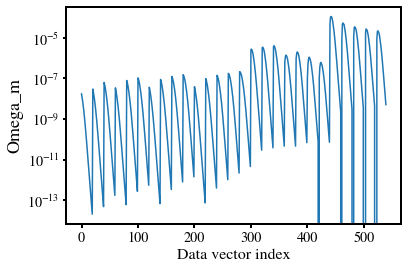

<ipython-input-12-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


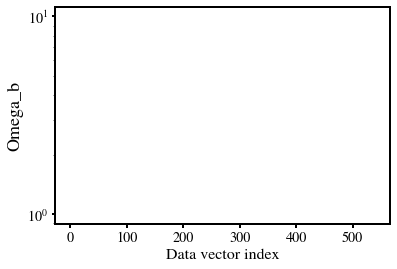

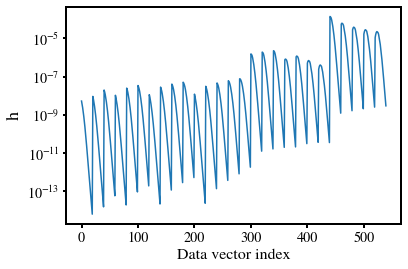

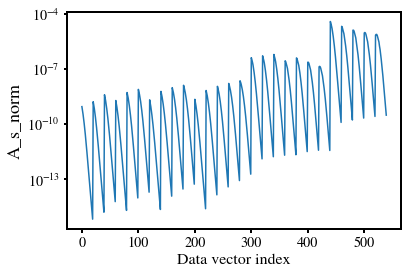

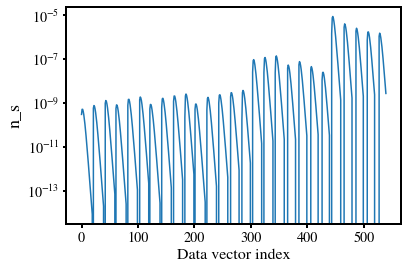

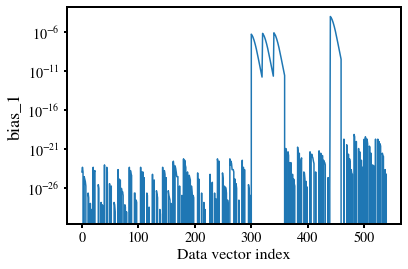

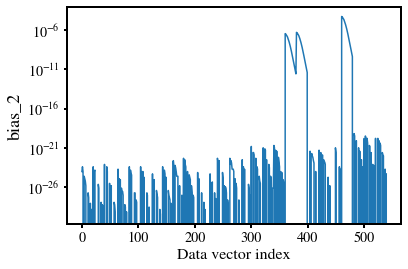

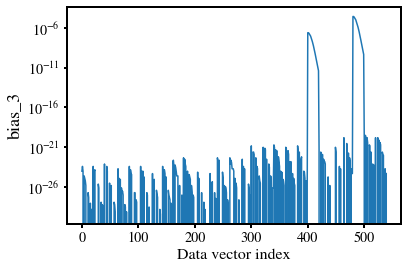

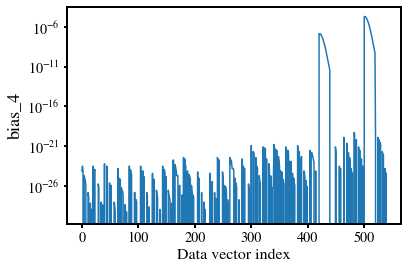

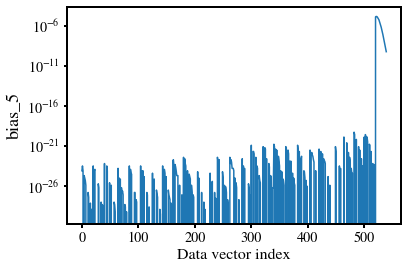

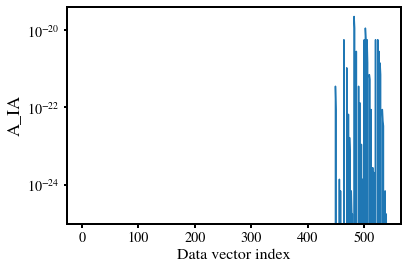

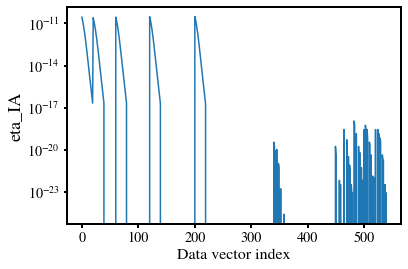

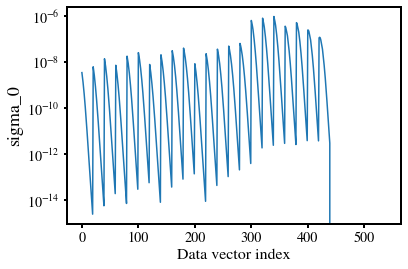

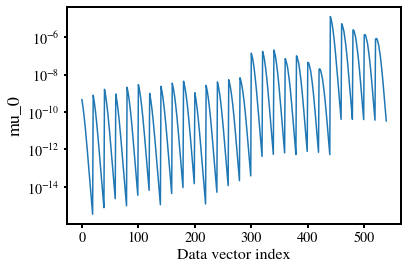

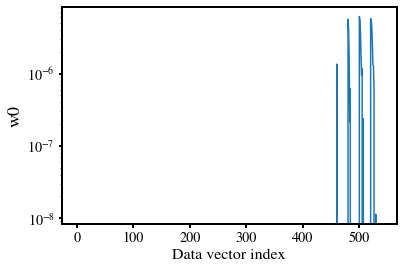

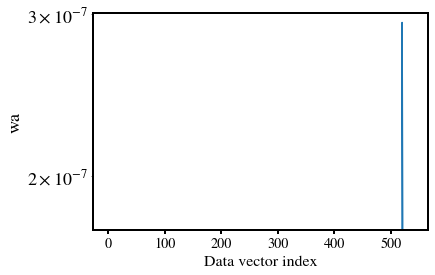

<ipython-input-12-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


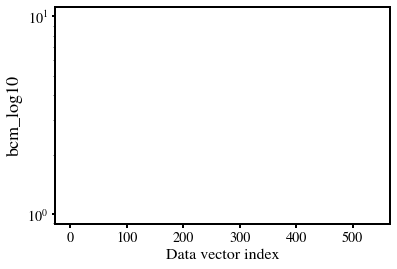

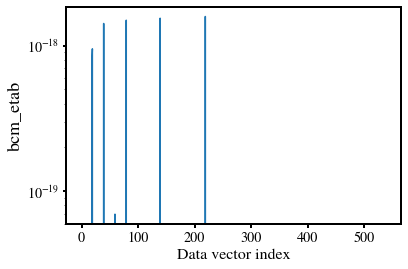

<ipython-input-12-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


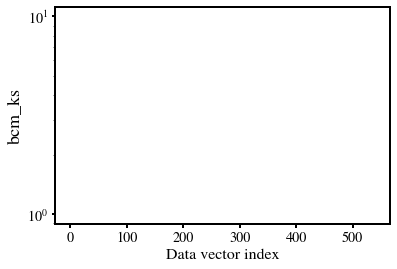

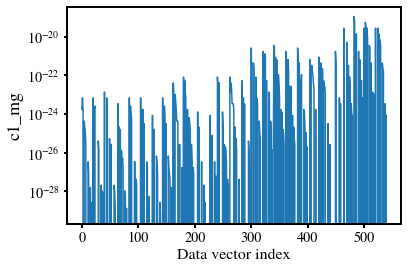

CCLError: Error CCL_ERROR_INTEG: ccl_cls.c: ccl_angular_cls_limber(); integration error


In [12]:
derivatives_linear = []
stepsize = 0.01
for param in derivative_names:
    deriv = numerical_deriv(param, stepsize, 'linear') #0.01 og
    derivatives_linear.append(deriv)
    plt.plot(deriv)
    plt.yscale('log')
    plt.ylabel(str(param), fontsize = 18)
    plt.xlabel('Data vector index', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

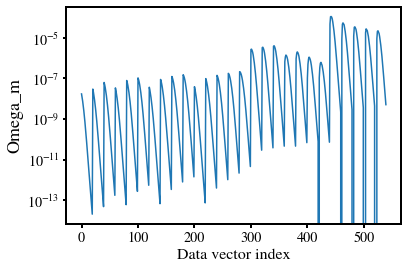

<ipython-input-16-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


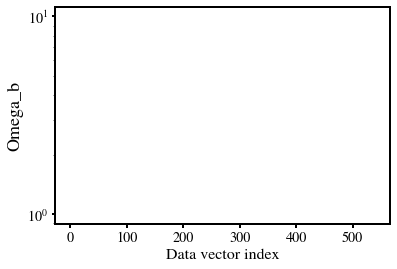

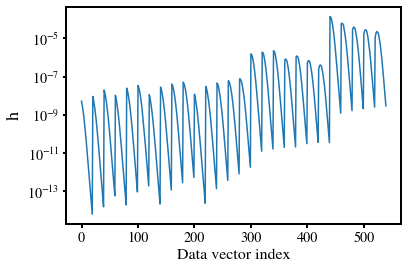

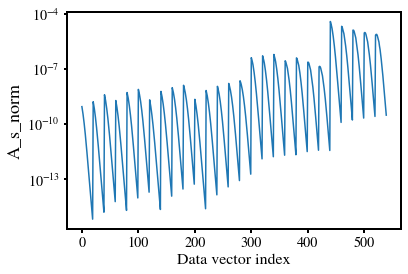

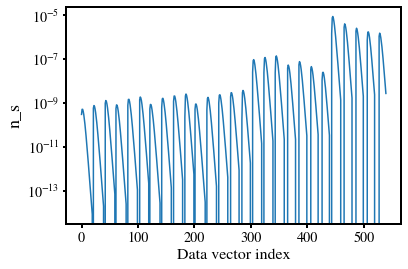

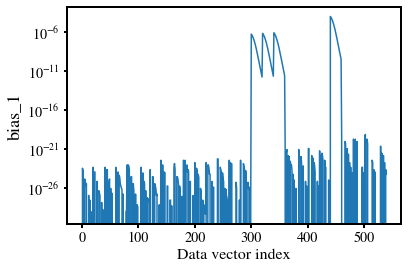

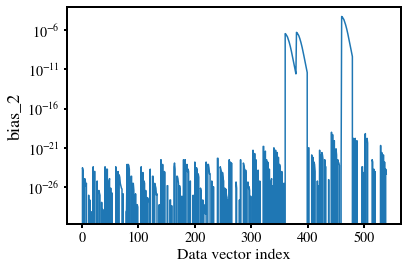

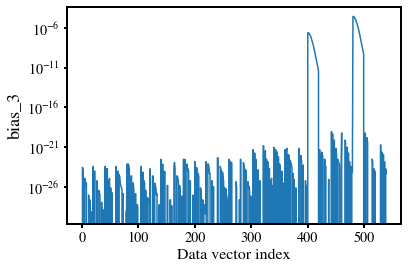

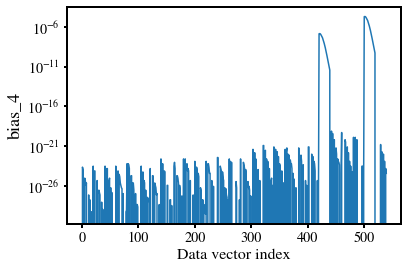

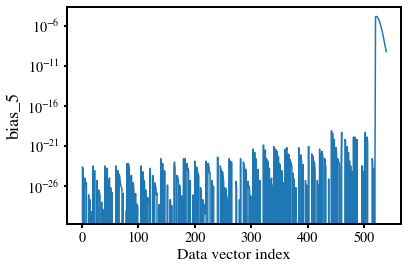

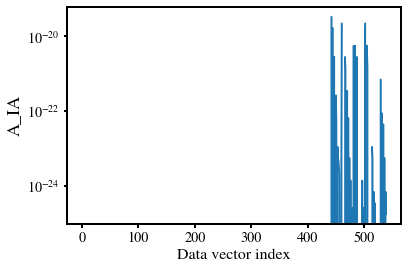

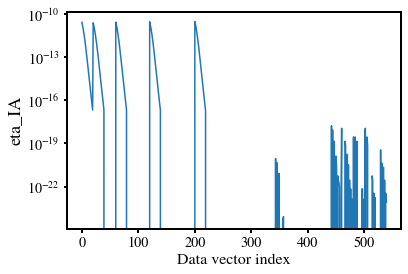

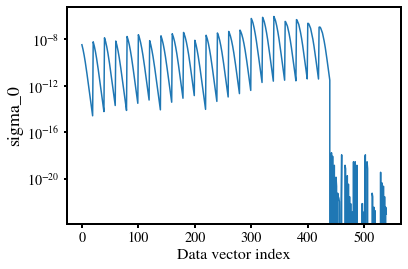

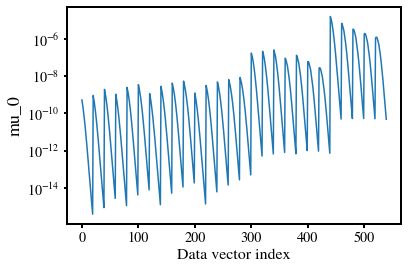

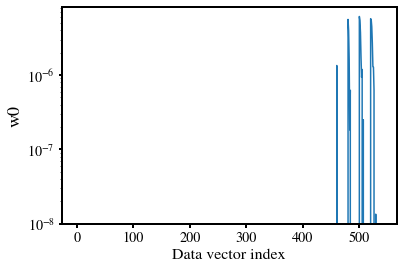

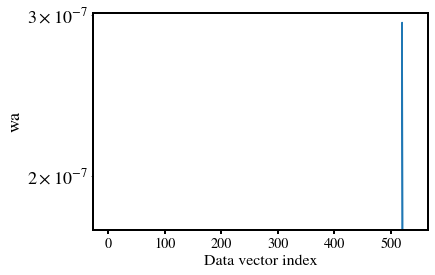

<ipython-input-16-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


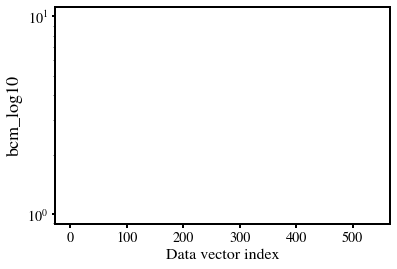

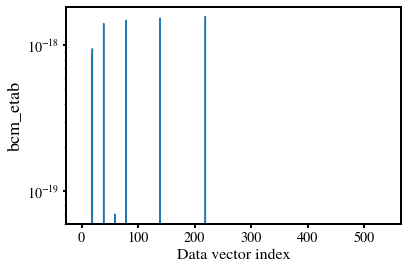

<ipython-input-16-10851f7877a5>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


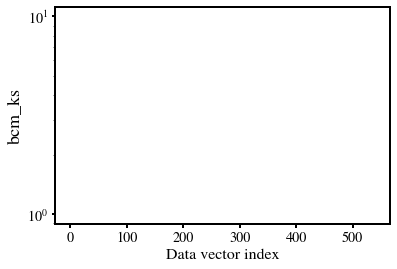

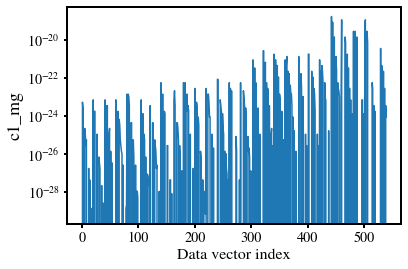

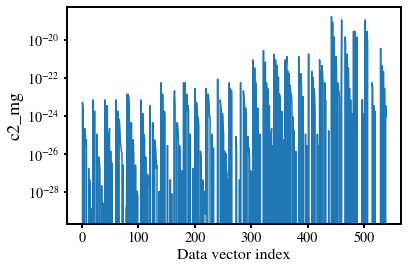

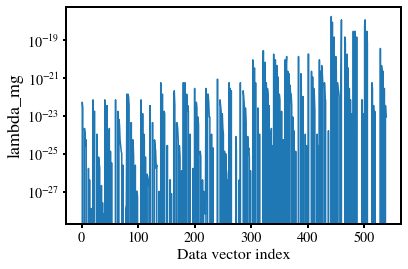

In [16]:
derivatives_linear = []
stepsize = 0.01
for param in derivative_names:
    deriv = numerical_deriv(param, stepsize, 'linear') #0.01 og
    derivatives_linear.append(deriv)
    plt.plot(deriv)
    plt.yscale('log')
    plt.ylabel(str(param), fontsize = 18)
    plt.xlabel('Data vector index', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

In [ ]:
#This plot is solely for the purpose of checking that all galaxy bias derivatives look right together

plt.plot(derivatives_linear[5], label = '$b_1$')
plt.plot(derivatives_linear[6], label = '$b_2$')
plt.plot(derivatives_linear[7], label = '$b_3$')
plt.plot(derivatives_linear[8], label = '$b_4$')
plt.plot(derivatives_linear[9], label = '$b_5$')

plt.yscale('log')
plt.ylabel('$\partial_{b_i}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

plt.show()

In [46]:
#Unfortunately, fisher object takes in derivatives file format, not just a list, let's make this right
#stepsize = 0.1
np.savetxt("derivatives_validation_IAbcm_scale_linear_step_"+str(stepsize)+".txt", np.vstack(derivatives_linear).T)
derivatives_linear = np.loadtxt("derivatives_validation_IAbcm_scale_linear_step_"+str(stepsize)+".txt")

## Load files from SRD: Covariance, fisher and prior

In [40]:
LSST_covinv_path = "/Users/agne/Documents/DESC/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/cov/Y1_3x2pt_inv"
LSST_covinv_file = np.loadtxt(LSST_covinv_path)

In [25]:
LSST_covinv = np.zeros([int(LSST_covinv_file[:,0].max()+1), int(LSST_covinv_file[:,0].max()+1)])

for ii in range(len(LSST_covinv_file)):
    row = int(LSST_covinv_file[ii][0])
    col = int(LSST_covinv_file[ii][1])
    LSST_covinv[row][col] = LSST_covinv_file[ii][2]

In [13]:
LSST_fisher_cosmo_file = np.load('/Users/agne/Documents/DESC/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/Fishers/Fisher_cosmo_Y1_3x2pt.npy')
LSST_fisher_file = np.load('/Users/agne/Documents/DESC/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/Fishers/Fisher_All_Y1_3x2pt.npy')
LSST_prior_now0wa_file = np.load('/Users/agne/Documents/DESC/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/Fishers/Fisher_cosmo_Stage3_excl_w0wa.npy')
LSST_prior_file = np.load('/Users/agne/Documents/DESC/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/Fishers/Fisher_cosmo_Stage3_incl_w0wa.npy')

In [15]:
LSST_cosmo_names = ['Omega_m', 'sigma_8', 'n_s', 'w0', 'wa', 'Omega_b', 'h']

LSST_full_names = ['Omega_m', 'sigma_8', 'n_s', 'w0', 'wa', 'Omega_b', 'h',\
                  'bias_1', 'bias_2', 'bias_3', 'bias_4', 'bias_5',\
                  'A_IA', 'beta_IA', 'eta_IA', 'eta_highz_IA']

In [28]:
LSST_full = fisherob(LSST_full_names, fisher_array=LSST_fisher_file)
#LSST_full.remove_elements - not needed, SRD has no modified gravity things
LSST_full.get_cov()
LSST_full.get_cov_cosmo(['Omega_m', 'n_s', 'w0', 'wa', 'Omega_b', 'h',\
                  'bias_1', 'bias_2', 'bias_3', 'bias_4', 'bias_5'])

The stds are positive - you're good to go!
The eigenvalues are positive - you're good to go!
added cosmo covariance with shape (11, 11)


## Comparison 

Here compare with IA+BCM version

In [33]:
derivatives_basic = np.loadtxt("derivatives_validation_IAbcm_linear_step_0.1.txt")

derivative_names_basic= ['Omega_m',\
               'Omega_b',\
               "h",\
               "A_s_norm",\
               "n_s",\
               "bias_1",\
               "bias_2",\
               "bias_3",\
               "bias_4",\
               "bias_5",\
               "A_IA",\
               "eta_IA",\
               "sigma_0",\
               "mu_0",\
               "w0",\
               "wa",\
               "bcm_log10",\
               "bcm_etab",\
               "bcm_ks" ]

In [34]:
# this cell computes fisher object and related covariance for the model without scale dependent parameters
fisher_cosmo_prior = fisherob(derivative_names_basic, derivatives_basic, inv_cov_file)
fisher_cosmo_prior.makefisher()
#no longer assume fixed
#fisher_cosmo_prior.remove_elements(['mu_0', 'sigma_0'])  #assume fixed
fisher_cosmo_prior.add_prior(LSST_prior_file, LSST_cosmo_names) #add prior on shared params only
fisher_cosmo_prior.get_cov()
fisher_cosmo_prior.get_cov_cosmo(names_keep = ['Omega_m', 'n_s', 'w0', 'wa', 'Omega_b', 'h', 'sigma_0',  'mu_0']) #this only gets the right params, not in right order
fisher_cosmo_prior.reshuffle_cosmo(['Omega_m', 'n_s', 'w0', 'wa', 'Omega_b', 'h', 'sigma_0',  'mu_0']) #puts things in right order

The parameters in current fisher do not match your prior - let me deal with this!
The stds are positive - you're good to go!
The eigenvalues are positive - you're good to go!
added cosmo covariance with shape (8, 8)
This will update the self.cov_cosmo and self.names_cosmo 


In [48]:
fisher_mgscale_cosmo_prior = fisherob(derivative_names, derivatives_linear, inv_cov_file)
fisher_mgscale_cosmo_prior.makefisher()
#if MG are fixed, linear gives negative eigenvalues error, if varied - singular matrix err
#fisher_mgscale_cosmo_prior.remove_elements(['c1_mg', 'c2_mg', 'lambda_mg'])  #assume fixed
#fisher_mgscale_cosmo_prior.add_prior(LSST_prior_file, LSST_cosmo_names) #add prior on shared params only
fisher_mgscale_cosmo_prior.get_cov()
fisher_mgscale_cosmo_prior.get_cov_cosmo(names_keep = ['Omega_m', 'n_s', 'w0', 'wa', 'Omega_b', 'h', 'sigma_0',  'mu_0']) #this only gets the right params, not in right order
fisher_mgscale_cosmo_prior.reshuffle_cosmo(['Omega_m', 'n_s', 'w0', 'wa', 'Omega_b', 'h', 'sigma_0',  'mu_0']) #puts things in right order

LinAlgError: Singular matrix

In [54]:
np.linalg.eig(fisher_mgscale_cosmo_prior.fisher)[0]

array([ 2.45580692e+07,  6.67362695e+05,  4.61583409e+04,  2.42105431e+04,
        2.07008264e+04,  1.69515868e+04,  1.26300712e+04,  1.03928846e+04,
        1.75485157e+03,  7.66067086e+02,  2.05938896e+02,  1.19115877e+02,
        1.82901139e+01,  4.95351006e+00,  1.28545471e+00,  2.83946004e-01,
        1.60640028e-01,  5.98447775e-02,  3.32637028e-07,  2.64873642e-22,
       -1.29907116e-40,  2.16815964e-40])

In [49]:
param_names_LSST_cosmo = ['Omega_m', 'n_s', 'w0', 'wa', 'omega_b', 'h0', 'sigma_0',  'mu_0']
labels_LSST_cosmo = [r'\Omega_{m}', r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}', r'\mu_0', r'\Sigma_0']
mean_LSST_cosmo = [0.3156, 0.96, -0.9, 0.0, 0.0450, 0.67, 0., 0.]


#gauss_LSST_cosmo_prior= GaussianND(mean_LSST_cosmo, LSST_cosmo_prior.cov_cosmo, names = param_names_LSST_cosmo)
gauss_fisher_cosmo_prior = GaussianND(mean_LSST_cosmo, fisher_cosmo_prior.cov_cosmo,  labels = labels_LSST_cosmo, names = param_names_LSST_cosmo )
gauss_fisher_mgscale_cosmo_prior = GaussianND(mean_LSST_cosmo, fisher_mgscale_cosmo_prior.cov_cosmo,  labels = labels_LSST_cosmo, names = param_names_LSST_cosmo )



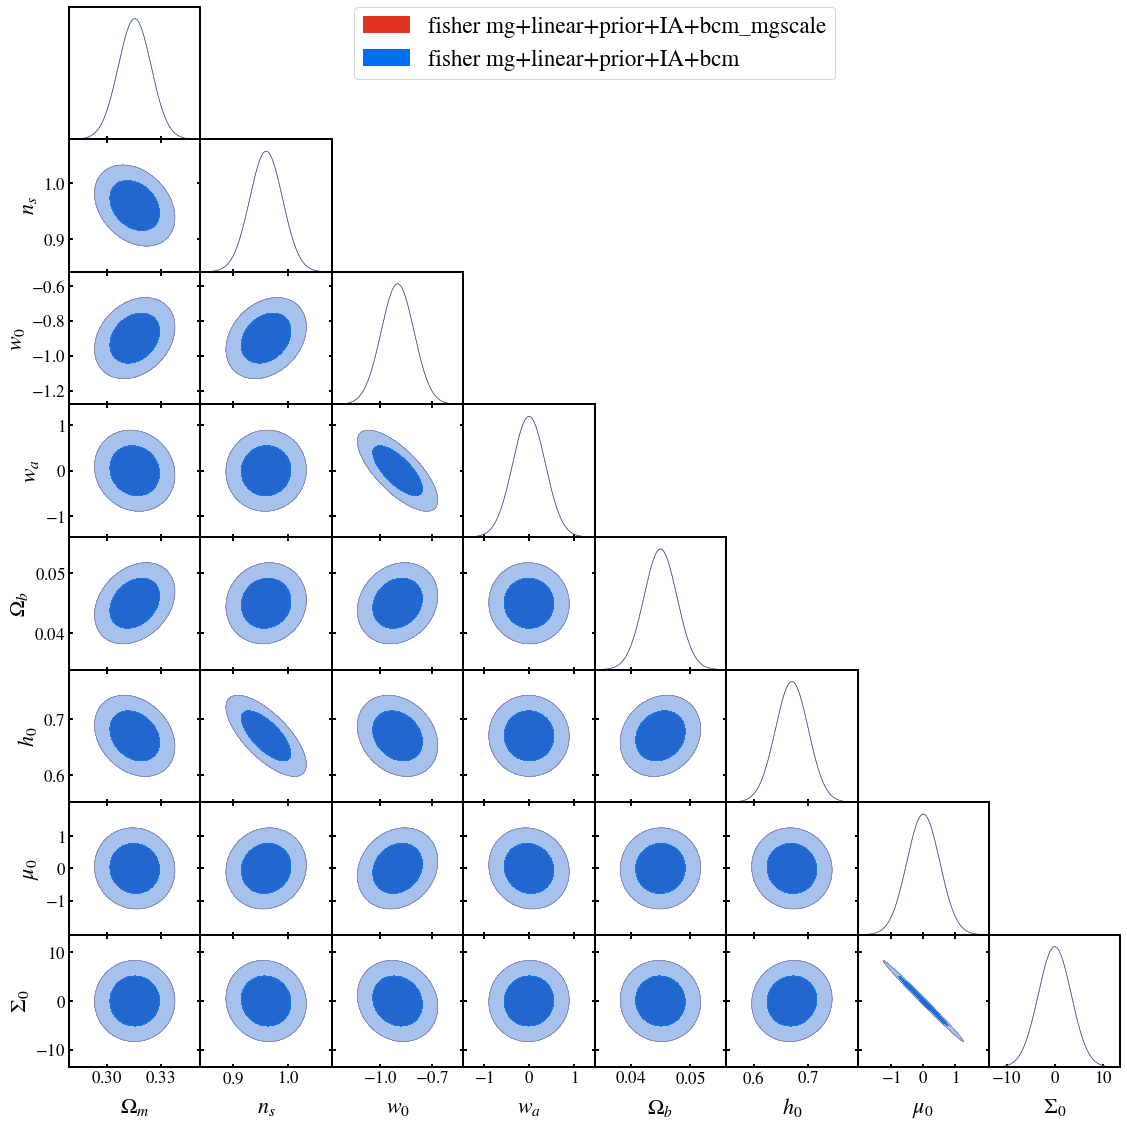

In [50]:
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 26
g.settings.axes_fontsize=20
g.settings.axes_labelsize=25
#g.triangle_plot([gauss_fisher_cosmo_prior, gauss_fisher_mg_cosmo_prior  ], filled = True, legend_labels=[ 'fisher linear+prior', 'fisher mg+linear+prior'])
g.triangle_plot([gauss_fisher_mgscale_cosmo_prior, gauss_fisher_cosmo_prior  ], filled = True, legend_labels=[  'fisher mg+linear+prior+IA+bcm_mgscale', 'fisher mg+linear+prior+IA+bcm'])
#pl.savefig("validation_mgscale_linear_cosmo.pdf")